## 1. Reading the data

### Package imports

In [108]:
import pandas as pd
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

In [109]:
from random import sample
import numpy as np
def add_noise(data, cx, sigma):
    nnp = int(cx*len(data))
    idx = sample(range(len(data)), nnp)
    noise = np.random.normal(0, sigma, nnp)
    for i in range(nnp):
        data[idx[i]] += noise[i]
    return data
def normalize(data):
    mini = np.amin(data)
    maxi = np.amax(data)
    for i in range(len(data)):
        data[i] = (data[i] - mini)/(maxi - mini)
    return data


In [110]:
import torch
import eval
import numpy as np
from torch import Tensor
from torch.autograd import Variable
def train(data, target, model, criterion, optimizer, epochs):
    model.train()
    clean_data = Variable(Tensor(data))
    target = Variable(Tensor(target))
    err = []
    for e in range(epochs):
    
        # Forward pass: Compute predicted y by passing x to the model
        if e % 2 == 0:
            pred_y = model(clean_data)
        else:
            noisy_data = []
            for d in data:
                nd = add_noise(np.copy(d), cx=0.25, sigma=randint(1, 9)/10**randint(1, 3))
                noisy_data.append(normalize(nd))
            noisy_data = np.array(noisy_data)
            pred_y = model(Variable(Tensor(noisy_data)))

        # Compute loss
        loss = criterion(pred_y, target)
        err.append(loss.item())
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return err
def test(data, target, model):
    model.eval()
    target_values = generate_rescaled_inputs(target)
    predicted_values = generate_predictions(data, model)
    return predicted_values, eval.compute_error_metrics(target_values, predicted_values)

def test_class(data, target, model):
    model.eval()
    predicted_values = generate_class_predictions(data, model)
    return predicted_values

#convert numpy array to 16x16 binary image
def generate_rescaled_inputs(data, s=16):
    input_data = []
    
    for i in range(len(data)):
        p = data[i]
        p = p.reshape(s, s)
        p[p <= 0.5] = 0
        p[p > 0.5] = 1
        input_data.append(p)
        
    return input_data

def generate_predictions(data, model):
    predicted_output = []
    with torch.no_grad():
        data = Variable(Tensor(data))
        pred = model(data).cpu().detach().numpy()
        for p in pred:
            p = p.reshape(16, 16)
            p[p <= 0.5] = 0
            p[p > 0.5] = 1
            predicted_output.append(p)
    
    return predicted_output

def generate_class_predictions(data, model):
    predicted_output = []
    with torch.no_grad():
        data = Variable(Tensor(data))
        pred = model(data).cpu().detach().numpy()
        for p in pred:
            p = p.reshape(9, 9)
            p = np.where(p == p.max(axis=1, keepdims=True), 1, 0)
            p = p.flatten()
            predicted_output.append(p)
    
    return predicted_output

In [111]:
import torch
from torch import tensor
import torch.nn as nn

class DeepNet(nn.Module):
    def __init__(self, layerSize, p=0) -> None:
        super(DeepNet, self).__init__()
        self.layers = nn.ModuleList()
        self.drop = nn.Dropout(p=p)
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()
        for inp_size, out_size in zip(layerSize[:-1], layerSize[1:]):
            self.layers.append(nn.Linear(inp_size, out_size))
    
    def forward(self, x):
        for linear in self.layers[:-1]:
            x = linear(x)
            x = self.relu(x)
            x = self.drop(x)
        linear = self.layers[-1]
        out = linear(x)
        out = self.sigm(out)
        return out

In [112]:
import numpy as np

def calculate_total_black_pixels(array):
    count = 0
    for a in array:
            count+= np.count_nonzero(a==0)
    return count

def calculate_total_white_pixels(array):
    count = 0
    for a in array:
            count+= np.count_nonzero(a==1)
    return count

def calculate_matching_black_pixels(data1, data2):
    match_ctr = 0
    inp = data1.flatten()
    pred = data2.flatten()
    for i in range(len(pred)):
        match_ctr += 1 if(inp[i]==0 and pred[i]==0) else 0
    return match_ctr

def calculate_mismatching_black_pixels(data1, data2):
    mismatch_ctr = 0
    inp = data1.flatten()
    pred = data2.flatten()
    for i in range(len(pred)):
        mismatch_ctr += 1 if(inp[i]==1 and pred[i]==0) else 0
    return mismatch_ctr

def compute_error_metrics(input_data, predicted_output):
    f_h = []
    f_fa = []
    
    for ix, data in enumerate(input_data):
        total_black_pixels = calculate_total_black_pixels(input_data[ix])
        total_hits = calculate_matching_black_pixels(input_data[ix], predicted_output[ix])
        fh_ratio = float(total_hits/total_black_pixels)
        # print("Fraction of hits is ", total_hits, total_black_pixels)
        f_h.append(fh_ratio)
    
    for ix, data in enumerate(input_data):
        total_white_pixels = calculate_total_white_pixels(input_data[ix])
        total_fa = calculate_mismatching_black_pixels(input_data[ix], predicted_output[ix])
        ffa_ratio = float(total_fa/total_white_pixels)
        # print("Fraction of false alarms is ", total_fa, total_white_pixels)
        f_fa.append(ffa_ratio)
    return f_h, f_fa


### Reading the images present in the 'dataset/sans/16x' directory (dataset-1)

In [113]:
data=[]
chars = [i for i in range(48, 48+10)] + [i for i in range(65, 65+26)]
for i in chars:
    img = cv2.imread('dataset/sans/16px/%s.jpg' %chr(i))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (threshi, final_img) = cv2.threshold(img_gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    data.append(np.array(final_img, dtype=np.float32).flatten())


### Displaying the input images

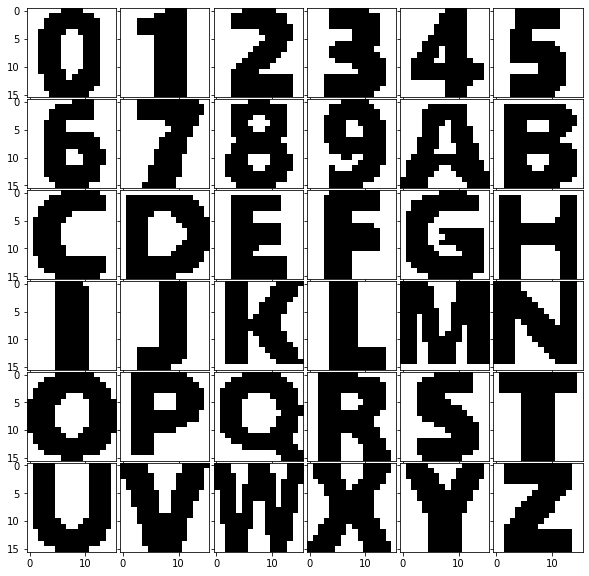

In [114]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(6, 6, hspace=0.02, wspace=0.02)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(36):
    axs[i//6, i%6].imshow(data[i].reshape(16, 16), 'gray')    

In [115]:
x_data = Variable(torch.Tensor([data]))
y_data = Variable(torch.Tensor([data]))

## 2. Model Designing and Training

In [116]:
from random import randint
# metrics for measuring the performance of the model
ffa = []
fh = []


model = DeepNet(layerSize=[256]+[256]*3+[256])
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
for epochs in range(0, 1100, 100):
    
    #Train the model with MSE loss criterion and Adam optimizer function
    train(data, data, model, criterion, optimizer, 100)
    
    # Compute errors and predicted output 
    pred, err = test(data=data, target=data, model=model)
    fh += [np.mean(err[0])]
    ffa += [np.mean(err[1])]

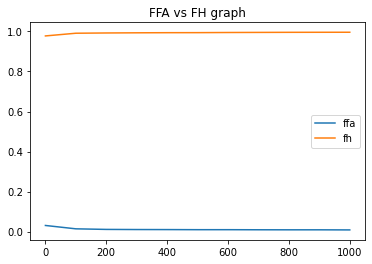

In [117]:
plt.plot(range(0, 1100, 100), ffa, label='ffa')
plt.plot(range(0, 1100, 100), fh, label='fh')

plt.title("FFA vs FH graph")
plt.legend()

### At 200 epochs we achieve FH and FFA scores of 0.99 and 0.13 respectively, which is why we have chosed to run the experiments with 200 epochs

In [118]:
model = DeepNet(layerSize=[256]+[256]*3+[256])
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train(data, data, model, criterion, optimizer, 250);

## 3. Testing the model

### Displaying the predicted images for running the model on dataset #1

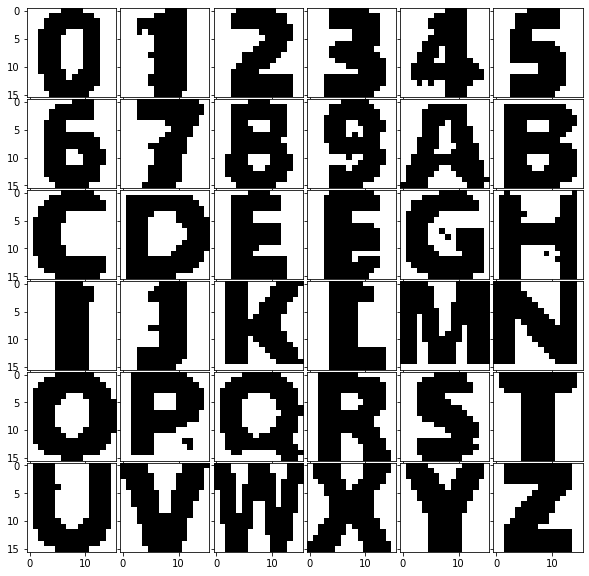

In [119]:
ffa = []
fh = []
pred, err = test(data=data, target=data, model=model)
fig = plt.figure(figsize=(10, 10))
fh += err[0]
ffa += err[1]
gs = fig.add_gridspec(6, 6, hspace=0.02, wspace=0.02)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(36):
    axs[i//6, i%6].imshow(pred[i], 'gray')    

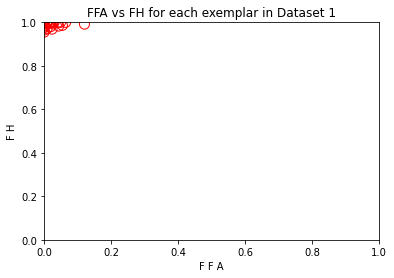

In [120]:
plt.scatter(ffa, fh, s=100, facecolors='none', edgecolors='r')
plt.title("FFA vs FH for each exemplar in Dataset 1")
plt.xlabel('F F A') 
plt.ylabel('F H') 
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

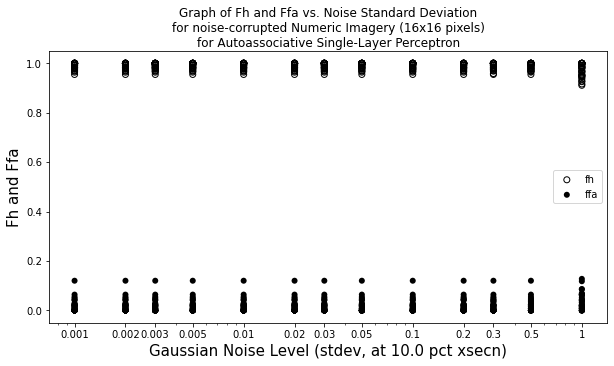

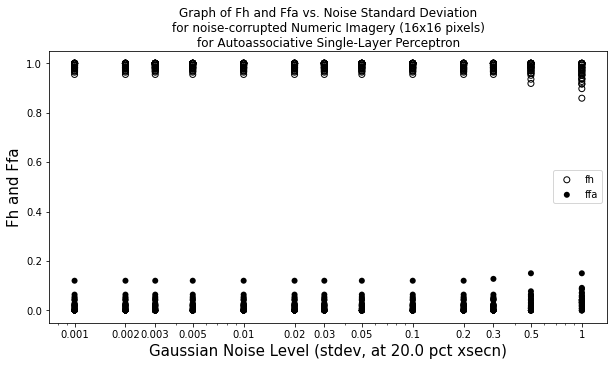

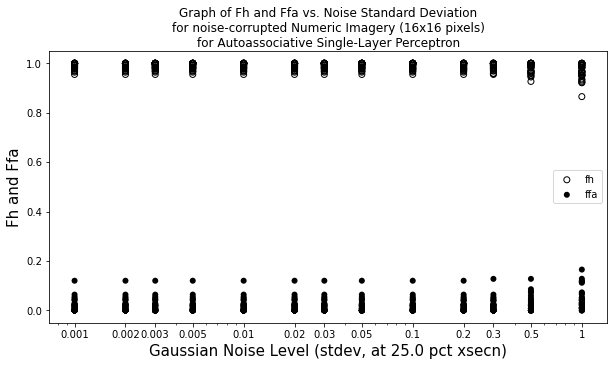

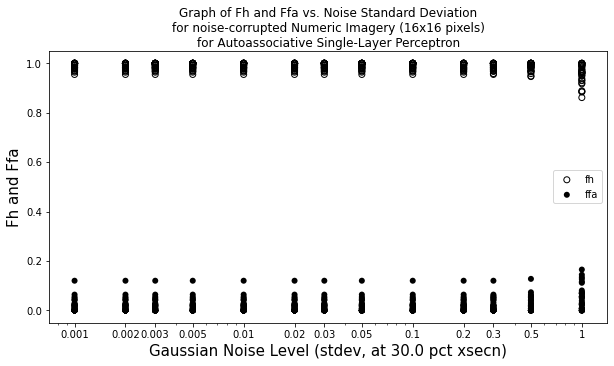

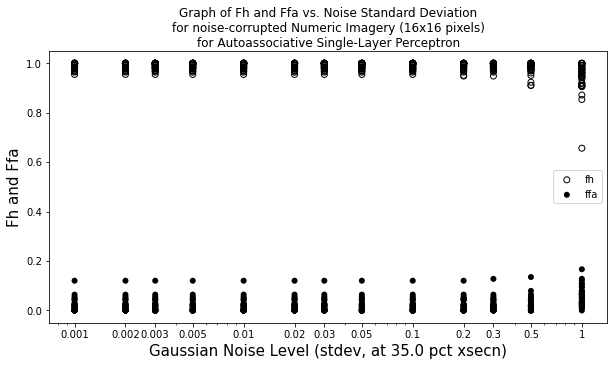

In [121]:
dfa = [pd.DataFrame()]*5
dfh = [pd.DataFrame()]*5
sigma = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
cxs = [0.1, 0.2, 0.25, 0.3, 0.35]
for i, cx in enumerate(cxs):
    ffa, fh = [], []
    dfa[i].index.name = 'Image ID'
    dfh[i].index.name = 'Image ID'
    for s in range(13):
        noisy_data = []
        for d in data:
            nd = add_noise(np.copy(d), cx, sigma[s])
            noisy_data.append(normalize(nd))
        target_values = generate_rescaled_inputs(data)
        predicted_values = generate_predictions(noisy_data, model)
        # for i in range(10):
        #     axs[i, s].imshow(predicted_values[i].reshape(16, 16))
        h, a = compute_error_metrics(target_values, predicted_values)
        ffa += a
        fh += h
        dfa[i]['%s' %sigma[s]] = a
        dfh[i]['%s' %sigma[s]] = h
    x = [[s]*36 for s in sigma]
    plt.figure(figsize=(10, 5))
    plt.title(("Graph of Fh and Ffa vs. Noise Standard Deviation\n"
        "for noise-corrupted Numeric Imagery (16x16 pixels)\n"
        "for Autoassociative Single-Layer Perceptron"), loc='center', wrap=True)
    plt.xlabel(f'Gaussian Noise Level (stdev, at {cx*100} pct xsecn)', size=15)
    plt.ylabel('Fh and Ffa', size=15)
    plt.xscale('log')
    plt.xticks(sigma, sigma)
    plt.scatter(x, fh, label='fh', facecolors='none', edgecolors='black')
    plt.scatter(x, ffa, label='ffa', facecolors='black', edgecolors='none')
    plt.legend()

In [122]:
from IPython.display import display
for i, cx in enumerate(cxs):
    print(f'ffa values at stdev for {cx*100} xsecn')
    display(dfa[i])

ffa values at stdev for 10.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007752,0.038760,0.054264
1,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608
2,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.046154
3,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.015873,0.023810,0.039683
4,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.107914
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007576,0.022727,0.030303,0.015152,0.121212
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022727,0.053030
7,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.068493
8,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.050847,0.067797


ffa values at stdev for 20.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007752,0.038760,0.054264
1,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608
2,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.046154
3,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.015873,0.023810,0.039683
4,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.107914
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007576,0.022727,0.030303,0.015152,0.121212
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022727,0.053030
7,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.068493
8,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.050847,0.067797


ffa values at stdev for 25.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007752,0.038760,0.054264
1,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608
2,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.046154
3,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.015873,0.023810,0.039683
4,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.107914
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007576,0.022727,0.030303,0.015152,0.121212
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022727,0.053030
7,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.068493
8,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.050847,0.067797


ffa values at stdev for 30.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007752,0.038760,0.054264
1,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608
2,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.046154
3,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.015873,0.023810,0.039683
4,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.107914
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007576,0.022727,0.030303,0.015152,0.121212
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022727,0.053030
7,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.068493
8,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.050847,0.067797


ffa values at stdev for 35.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007752,0.038760,0.054264
1,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608
2,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.015385,0.046154
3,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.007937,0.015873,0.023810,0.039683
4,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.043165,0.107914
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007576,0.022727,0.030303,0.015152,0.121212
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022727,0.053030
7,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.068493
8,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.050847,0.067797


In [123]:
from IPython.display import display
for i, cx in enumerate(cxs):
    print(f'fh values at stdev for {cx*100} xsecn')
    display(dfh[i])

fh values at stdev for 10.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.976378,0.944882
1,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.920635
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.992308,0.969231,0.853846
4,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.871795
5,0.983871,0.983871,0.983871,0.983871,0.983871,0.983871,0.983871,0.983871,0.975806,0.951613,0.975806,0.975806,0.951613
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991935,0.991935
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.918182
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.905797


fh values at stdev for 20.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.976378,0.944882
1,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.920635
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.992308,0.969231,0.853846
4,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.871795
5,0.983871,0.983871,0.983871,0.983871,0.983871,0.983871,0.983871,0.983871,0.975806,0.951613,0.975806,0.975806,0.951613
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991935,0.991935
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.918182
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.905797


fh values at stdev for 25.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.976378,0.944882
1,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.920635
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.992308,0.969231,0.853846
4,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.871795
5,0.983871,0.983871,0.983871,0.983871,0.983871,0.983871,0.983871,0.983871,0.975806,0.951613,0.975806,0.975806,0.951613
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991935,0.991935
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.918182
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.905797


fh values at stdev for 30.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.976378,0.944882
1,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.920635
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.992308,0.969231,0.853846
4,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.871795
5,0.983871,0.983871,0.983871,0.983871,0.983871,0.983871,0.983871,0.983871,0.975806,0.951613,0.975806,0.975806,0.951613
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991935,0.991935
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.918182
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.905797


fh values at stdev for 35.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.992126,0.976378,0.944882
1,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.920635
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.992308,0.969231,0.853846
4,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.871795
5,0.983871,0.983871,0.983871,0.983871,0.983871,0.983871,0.983871,0.983871,0.975806,0.951613,0.975806,0.975806,0.951613
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991935,0.991935
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.918182
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.905797


### reading the dataset #2

In [124]:
#read images
serif=[]
chars = [i for i in range(48, 48+10)] + [i for i in range(65, 65+26)]
for i in chars:
    img = cv2.imread('dataset/serif/16px/%s.jpg' %chr(i))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (threshi, final_img) = cv2.threshold(img_gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    serif.append(np.array(final_img, dtype=np.float32).flatten())


### Testing the model against dataset #2

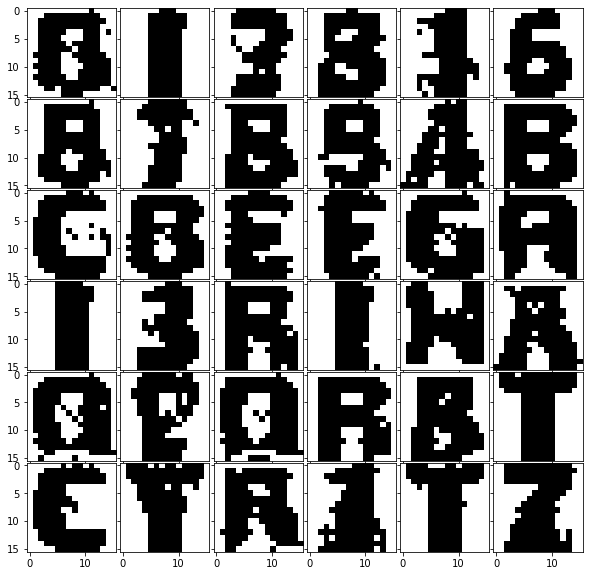

In [125]:
fh_e, ffa_e = [], []
pred, err = test(data=serif, target=data, model=model)

fh_e += err[0]
ffa_e += err[1]

fh = [np.median(err[0]), np.mean(err[0]), np.std(err[0])]
ffa = [np.median(err[1]), np.mean(err[1]), np.std(err[1])]
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(6, 6, hspace=0.02, wspace=0.02)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(36):
    axs[i//6, i%6].imshow(pred[i], 'gray')    


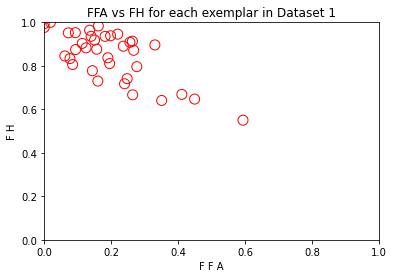

In [126]:
plt.scatter(ffa_e, fh_e, s=100, facecolors='none', edgecolors='r')
plt.title("FFA vs FH for each exemplar in Dataset 1")
plt.xlabel('F F A') 
plt.ylabel('F H') 
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

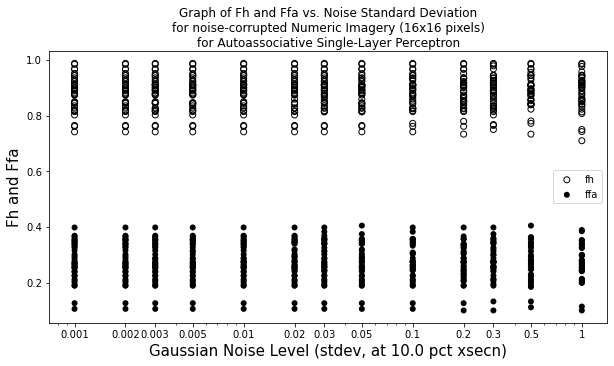

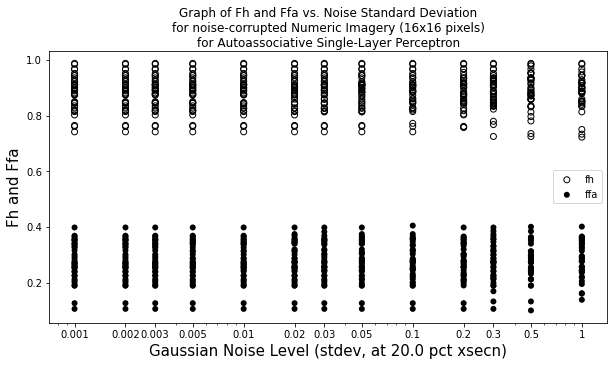

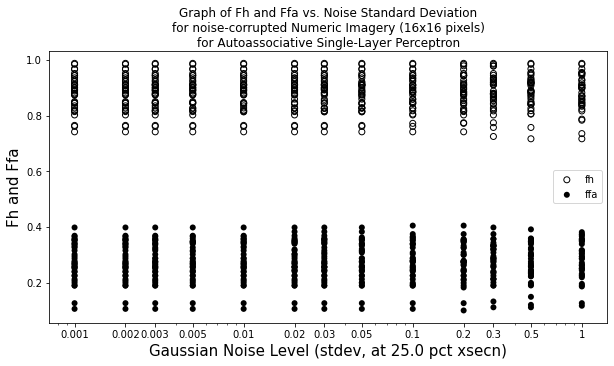

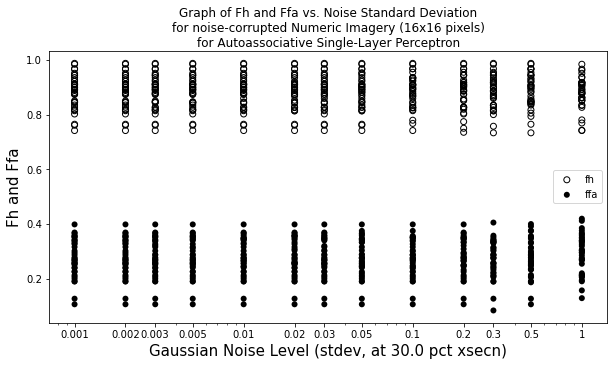

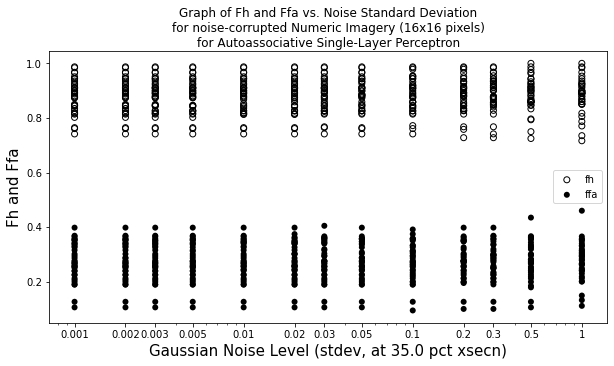

In [127]:
dfa = [pd.DataFrame()]*5
dfh = [pd.DataFrame()]*5
sigma = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
cxs = [0.1, 0.2, 0.25, 0.3, 0.35]
for i, cx in enumerate(cxs):
    ffa, fh = [], []
    dfa[i].index.name = 'Image ID'
    dfh[i].index.name = 'Image ID'
    for s in range(13):
        noisy_data = []
        for d in serif:
            nd = add_noise(np.copy(d), cx, sigma[s])
            noisy_data.append(normalize(nd))
        target_values = generate_rescaled_inputs(serif)
        predicted_values = generate_predictions(noisy_data, model)
        # for i in range(10):
        #     axs[i, s].imshow(predicted_values[i].reshape(16, 16))
        h, a = compute_error_metrics(target_values, predicted_values)
        ffa += a
        fh += h
        dfa[i]['%s' %sigma[s]] = a
        dfh[i]['%s' %sigma[s]] = h
    x = [[s]*36 for s in sigma]
    plt.figure(figsize=(10, 5))
    plt.title(("Graph of Fh and Ffa vs. Noise Standard Deviation\n"
        "for noise-corrupted Numeric Imagery (16x16 pixels)\n"
        "for Autoassociative Single-Layer Perceptron"), loc='center', wrap=True)
    plt.xlabel(f'Gaussian Noise Level (stdev, at {cx*100} pct xsecn)', size=15)
    plt.ylabel('Fh and Ffa', size=15)
    plt.xscale('log')
    plt.xticks(sigma, sigma)
    plt.scatter(x, fh, label='fh', facecolors='none', edgecolors='black')
    plt.scatter(x, ffa, label='ffa', facecolors='black', edgecolors='none')
    plt.legend()

In [128]:
from IPython.display import display
for i, cx in enumerate(cxs):
    print(f'ffa values at stdev for {cx*100} xsecn')
    display(dfa[i])

ffa values at stdev for 10.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.353741,0.353741,0.353741,0.353741,0.346939,0.340136,0.360544,0.346939,0.326531,0.326531,0.299320,0.435374,0.292517
1,0.106742,0.106742,0.106742,0.106742,0.106742,0.106742,0.106742,0.106742,0.095506,0.101124,0.101124,0.106742,0.112360
2,0.239264,0.239264,0.239264,0.239264,0.245399,0.245399,0.245399,0.245399,0.233129,0.276074,0.251534,0.282209,0.263804
3,0.369048,0.369048,0.369048,0.369048,0.369048,0.363095,0.363095,0.357143,0.351190,0.363095,0.369048,0.363095,0.333333
4,0.207101,0.207101,0.207101,0.207101,0.207101,0.207101,0.207101,0.207101,0.201183,0.213018,0.213018,0.218935,0.230769
5,0.269461,0.269461,0.269461,0.275449,0.269461,0.269461,0.275449,0.275449,0.269461,0.275449,0.281437,0.335329,0.299401
6,0.268966,0.268966,0.268966,0.268966,0.268966,0.262069,0.268966,0.268966,0.262069,0.268966,0.296552,0.255172,0.241379
7,0.225641,0.225641,0.225641,0.225641,0.225641,0.225641,0.225641,0.225641,0.220513,0.225641,0.225641,0.241026,0.266667
8,0.326667,0.326667,0.326667,0.326667,0.326667,0.326667,0.320000,0.326667,0.313333,0.300000,0.300000,0.300000,0.313333


ffa values at stdev for 20.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.353741,0.353741,0.353741,0.353741,0.346939,0.340136,0.360544,0.346939,0.326531,0.326531,0.299320,0.435374,0.292517
1,0.106742,0.106742,0.106742,0.106742,0.106742,0.106742,0.106742,0.106742,0.095506,0.101124,0.101124,0.106742,0.112360
2,0.239264,0.239264,0.239264,0.239264,0.245399,0.245399,0.245399,0.245399,0.233129,0.276074,0.251534,0.282209,0.263804
3,0.369048,0.369048,0.369048,0.369048,0.369048,0.363095,0.363095,0.357143,0.351190,0.363095,0.369048,0.363095,0.333333
4,0.207101,0.207101,0.207101,0.207101,0.207101,0.207101,0.207101,0.207101,0.201183,0.213018,0.213018,0.218935,0.230769
5,0.269461,0.269461,0.269461,0.275449,0.269461,0.269461,0.275449,0.275449,0.269461,0.275449,0.281437,0.335329,0.299401
6,0.268966,0.268966,0.268966,0.268966,0.268966,0.262069,0.268966,0.268966,0.262069,0.268966,0.296552,0.255172,0.241379
7,0.225641,0.225641,0.225641,0.225641,0.225641,0.225641,0.225641,0.225641,0.220513,0.225641,0.225641,0.241026,0.266667
8,0.326667,0.326667,0.326667,0.326667,0.326667,0.326667,0.320000,0.326667,0.313333,0.300000,0.300000,0.300000,0.313333


ffa values at stdev for 25.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.353741,0.353741,0.353741,0.353741,0.346939,0.340136,0.360544,0.346939,0.326531,0.326531,0.299320,0.435374,0.292517
1,0.106742,0.106742,0.106742,0.106742,0.106742,0.106742,0.106742,0.106742,0.095506,0.101124,0.101124,0.106742,0.112360
2,0.239264,0.239264,0.239264,0.239264,0.245399,0.245399,0.245399,0.245399,0.233129,0.276074,0.251534,0.282209,0.263804
3,0.369048,0.369048,0.369048,0.369048,0.369048,0.363095,0.363095,0.357143,0.351190,0.363095,0.369048,0.363095,0.333333
4,0.207101,0.207101,0.207101,0.207101,0.207101,0.207101,0.207101,0.207101,0.201183,0.213018,0.213018,0.218935,0.230769
5,0.269461,0.269461,0.269461,0.275449,0.269461,0.269461,0.275449,0.275449,0.269461,0.275449,0.281437,0.335329,0.299401
6,0.268966,0.268966,0.268966,0.268966,0.268966,0.262069,0.268966,0.268966,0.262069,0.268966,0.296552,0.255172,0.241379
7,0.225641,0.225641,0.225641,0.225641,0.225641,0.225641,0.225641,0.225641,0.220513,0.225641,0.225641,0.241026,0.266667
8,0.326667,0.326667,0.326667,0.326667,0.326667,0.326667,0.320000,0.326667,0.313333,0.300000,0.300000,0.300000,0.313333


ffa values at stdev for 30.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.353741,0.353741,0.353741,0.353741,0.346939,0.340136,0.360544,0.346939,0.326531,0.326531,0.299320,0.435374,0.292517
1,0.106742,0.106742,0.106742,0.106742,0.106742,0.106742,0.106742,0.106742,0.095506,0.101124,0.101124,0.106742,0.112360
2,0.239264,0.239264,0.239264,0.239264,0.245399,0.245399,0.245399,0.245399,0.233129,0.276074,0.251534,0.282209,0.263804
3,0.369048,0.369048,0.369048,0.369048,0.369048,0.363095,0.363095,0.357143,0.351190,0.363095,0.369048,0.363095,0.333333
4,0.207101,0.207101,0.207101,0.207101,0.207101,0.207101,0.207101,0.207101,0.201183,0.213018,0.213018,0.218935,0.230769
5,0.269461,0.269461,0.269461,0.275449,0.269461,0.269461,0.275449,0.275449,0.269461,0.275449,0.281437,0.335329,0.299401
6,0.268966,0.268966,0.268966,0.268966,0.268966,0.262069,0.268966,0.268966,0.262069,0.268966,0.296552,0.255172,0.241379
7,0.225641,0.225641,0.225641,0.225641,0.225641,0.225641,0.225641,0.225641,0.220513,0.225641,0.225641,0.241026,0.266667
8,0.326667,0.326667,0.326667,0.326667,0.326667,0.326667,0.320000,0.326667,0.313333,0.300000,0.300000,0.300000,0.313333


ffa values at stdev for 35.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.353741,0.353741,0.353741,0.353741,0.346939,0.340136,0.360544,0.346939,0.326531,0.326531,0.299320,0.435374,0.292517
1,0.106742,0.106742,0.106742,0.106742,0.106742,0.106742,0.106742,0.106742,0.095506,0.101124,0.101124,0.106742,0.112360
2,0.239264,0.239264,0.239264,0.239264,0.245399,0.245399,0.245399,0.245399,0.233129,0.276074,0.251534,0.282209,0.263804
3,0.369048,0.369048,0.369048,0.369048,0.369048,0.363095,0.363095,0.357143,0.351190,0.363095,0.369048,0.363095,0.333333
4,0.207101,0.207101,0.207101,0.207101,0.207101,0.207101,0.207101,0.207101,0.201183,0.213018,0.213018,0.218935,0.230769
5,0.269461,0.269461,0.269461,0.275449,0.269461,0.269461,0.275449,0.275449,0.269461,0.275449,0.281437,0.335329,0.299401
6,0.268966,0.268966,0.268966,0.268966,0.268966,0.262069,0.268966,0.268966,0.262069,0.268966,0.296552,0.255172,0.241379
7,0.225641,0.225641,0.225641,0.225641,0.225641,0.225641,0.225641,0.225641,0.220513,0.225641,0.225641,0.241026,0.266667
8,0.326667,0.326667,0.326667,0.326667,0.326667,0.326667,0.320000,0.326667,0.313333,0.300000,0.300000,0.300000,0.313333


In [129]:
from IPython.display import display
for i, cx in enumerate(cxs):
    print(f'fh values at stdev for {cx*100} xsecn')
    display(dfh[i])

fh values at stdev for 10.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.899083,0.899083,0.899083,0.899083,0.899083,0.908257,0.908257,0.899083,0.917431,0.908257,0.926606,0.899083,0.889908
1,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179
2,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.827957,0.827957,0.870968,0.860215
3,0.965909,0.965909,0.965909,0.965909,0.965909,0.965909,0.965909,0.965909,0.954545,0.965909,0.954545,0.977273,0.897727
4,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.885057,0.873563,0.862069,0.850575
5,0.921348,0.921348,0.921348,0.921348,0.921348,0.921348,0.921348,0.932584,0.932584,0.932584,0.932584,0.932584,0.943820
6,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.900901,0.918919,0.891892,0.891892
7,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.967213,0.967213,0.967213
8,0.943396,0.943396,0.943396,0.943396,0.943396,0.943396,0.943396,0.943396,0.952830,0.933962,0.943396,0.943396,0.924528


fh values at stdev for 20.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.899083,0.899083,0.899083,0.899083,0.899083,0.908257,0.908257,0.899083,0.917431,0.908257,0.926606,0.899083,0.889908
1,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179
2,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.827957,0.827957,0.870968,0.860215
3,0.965909,0.965909,0.965909,0.965909,0.965909,0.965909,0.965909,0.965909,0.954545,0.965909,0.954545,0.977273,0.897727
4,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.885057,0.873563,0.862069,0.850575
5,0.921348,0.921348,0.921348,0.921348,0.921348,0.921348,0.921348,0.932584,0.932584,0.932584,0.932584,0.932584,0.943820
6,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.900901,0.918919,0.891892,0.891892
7,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.967213,0.967213,0.967213
8,0.943396,0.943396,0.943396,0.943396,0.943396,0.943396,0.943396,0.943396,0.952830,0.933962,0.943396,0.943396,0.924528


fh values at stdev for 25.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.899083,0.899083,0.899083,0.899083,0.899083,0.908257,0.908257,0.899083,0.917431,0.908257,0.926606,0.899083,0.889908
1,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179
2,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.827957,0.827957,0.870968,0.860215
3,0.965909,0.965909,0.965909,0.965909,0.965909,0.965909,0.965909,0.965909,0.954545,0.965909,0.954545,0.977273,0.897727
4,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.885057,0.873563,0.862069,0.850575
5,0.921348,0.921348,0.921348,0.921348,0.921348,0.921348,0.921348,0.932584,0.932584,0.932584,0.932584,0.932584,0.943820
6,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.900901,0.918919,0.891892,0.891892
7,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.967213,0.967213,0.967213
8,0.943396,0.943396,0.943396,0.943396,0.943396,0.943396,0.943396,0.943396,0.952830,0.933962,0.943396,0.943396,0.924528


fh values at stdev for 30.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.899083,0.899083,0.899083,0.899083,0.899083,0.908257,0.908257,0.899083,0.917431,0.908257,0.926606,0.899083,0.889908
1,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179
2,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.827957,0.827957,0.870968,0.860215
3,0.965909,0.965909,0.965909,0.965909,0.965909,0.965909,0.965909,0.965909,0.954545,0.965909,0.954545,0.977273,0.897727
4,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.885057,0.873563,0.862069,0.850575
5,0.921348,0.921348,0.921348,0.921348,0.921348,0.921348,0.921348,0.932584,0.932584,0.932584,0.932584,0.932584,0.943820
6,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.900901,0.918919,0.891892,0.891892
7,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.967213,0.967213,0.967213
8,0.943396,0.943396,0.943396,0.943396,0.943396,0.943396,0.943396,0.943396,0.952830,0.933962,0.943396,0.943396,0.924528


fh values at stdev for 35.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.899083,0.899083,0.899083,0.899083,0.899083,0.908257,0.908257,0.899083,0.917431,0.908257,0.926606,0.899083,0.889908
1,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179
2,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.817204,0.827957,0.827957,0.870968,0.860215
3,0.965909,0.965909,0.965909,0.965909,0.965909,0.965909,0.965909,0.965909,0.954545,0.965909,0.954545,0.977273,0.897727
4,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.873563,0.885057,0.873563,0.862069,0.850575
5,0.921348,0.921348,0.921348,0.921348,0.921348,0.921348,0.921348,0.932584,0.932584,0.932584,0.932584,0.932584,0.943820
6,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.909910,0.900901,0.918919,0.891892,0.891892
7,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.950820,0.967213,0.967213,0.967213
8,0.943396,0.943396,0.943396,0.943396,0.943396,0.943396,0.943396,0.943396,0.952830,0.933962,0.943396,0.943396,0.924528


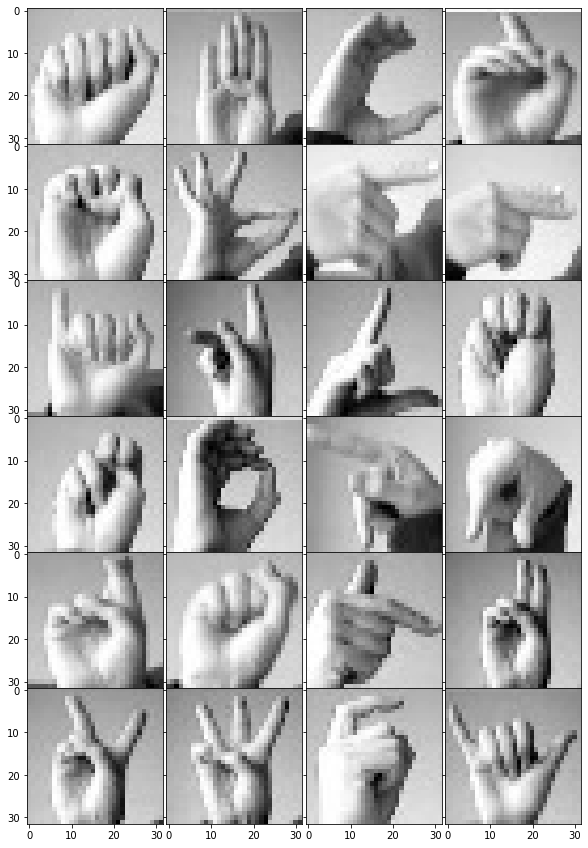

In [130]:
asl = []
asl_targets = []
ach = [i for i in range(65, 65+25)]
ach.remove(ord('J'))
for i in ach:
    img = cv2.imread('dataset/asl/32px/%s.jpg' %chr(i))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    im = np.array(img_gray, dtype=np.float32).flatten()
    im = im/255
    asl.append(im)
    img = cv2.imread('dataset/sans/16px/%s.jpg' %chr(i))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (threshi, final_img) = cv2.threshold(img_gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    asl_targets.append(np.array(final_img, dtype=np.float32).flatten())
fig = plt.figure(figsize=(10, 15))
gs = fig.add_gridspec(6, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(24):
    axs[i//4, i%4].imshow(asl[i].reshape(32, 32), 'gray')

In [131]:
ffa = []
fh = []
asl_model = DeepNet(layerSize=[1024]+[1024, 512, 256]+[256])
criterion = torch.nn.MSELoss(size_average = False)
optimizer = torch.optim.Adam(asl_model.parameters(), lr = 0.001)
for epochs in range(100, 1100, 100):
    train(asl, asl_targets, asl_model, criterion, optimizer, 100)
    pred, err = test(data=asl, target=asl_targets, model=asl_model)
    ffa += [np.mean(err[0])]
    fh += [np.mean(err[1])]

/Users/shivambang/miniforge3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


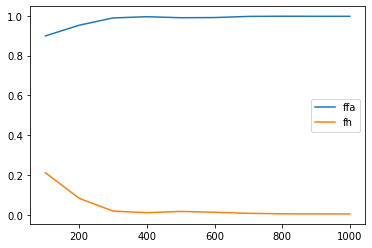

In [132]:
plt.figure()
plt.plot(range(100, 1100, 100), ffa, label='ffa')
plt.plot(range(100, 1100, 100), fh, label='fh')
plt.legend()    

In [133]:
model = DeepNet(layerSize=[1024]+[1024, 512, 256]+[256])
criterion = torch.nn.MSELoss(size_average = False)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train(asl, asl_targets, asl_model, criterion, optimizer, 450);

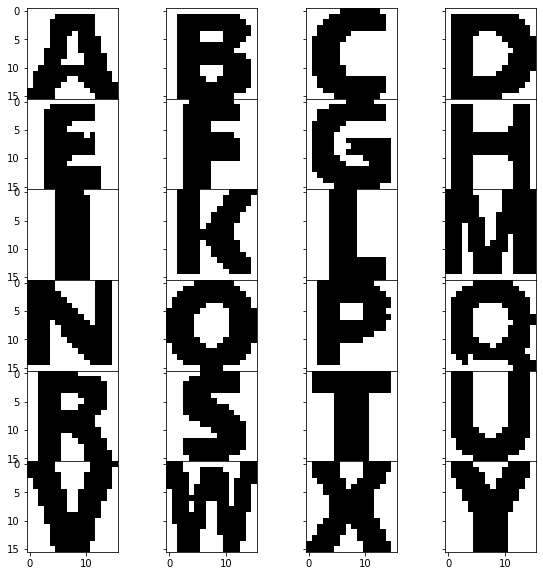

In [134]:
pred, err = test(data=asl, target=asl_targets, model=asl_model)
fh = [err[0]]
ffa = [err[1]]
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(6, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(24):
    axs[i//4, i%4].imshow(pred[i], 'gray')    

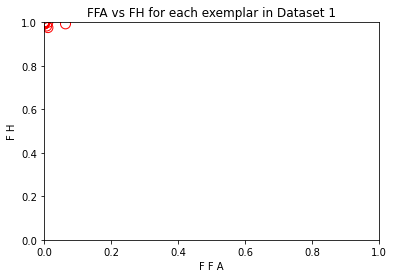

In [135]:
plt.scatter(ffa, fh, s=100, facecolors='none', edgecolors='r')
plt.title("FFA vs FH for each exemplar in Dataset 1")
plt.xlabel('F F A') 
plt.ylabel('F H') 
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

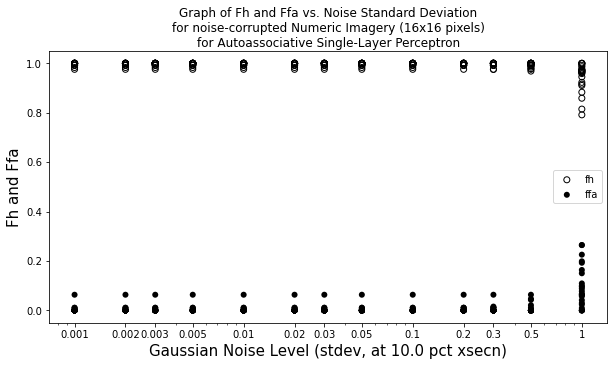

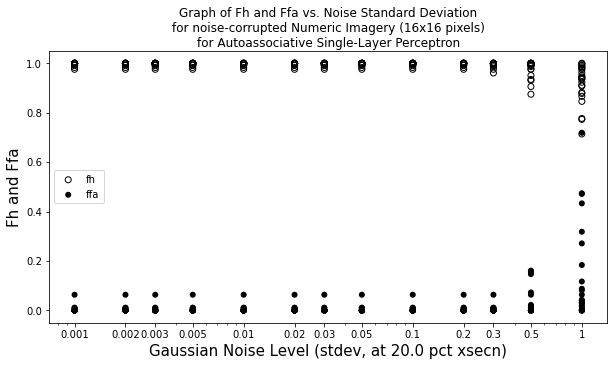

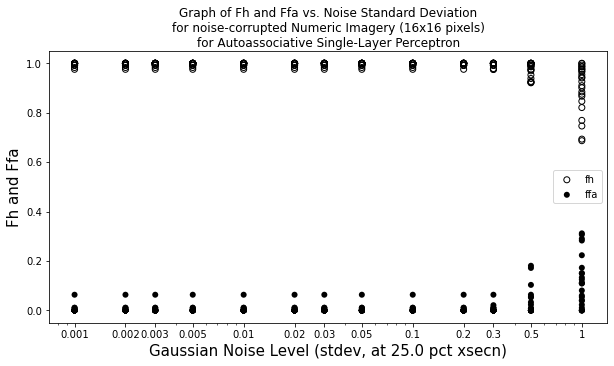

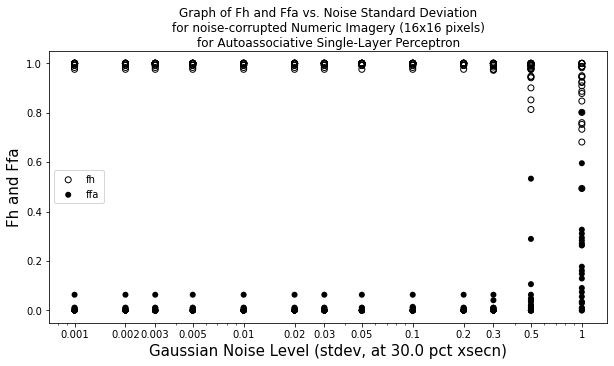

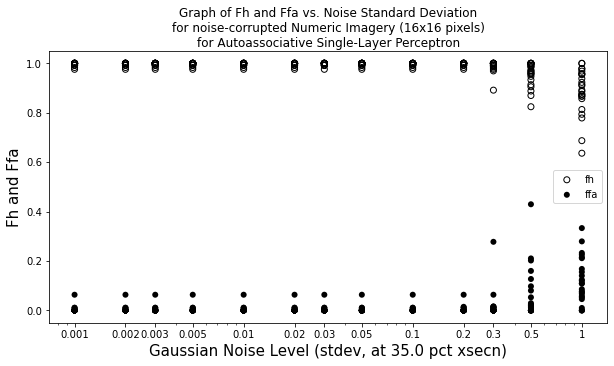

In [136]:
dfa = [pd.DataFrame()]*5
dfh = [pd.DataFrame()]*5
sigma = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
cxs = [0.1, 0.2, 0.25, 0.3, 0.35]
for i, cx in enumerate(cxs):
    ffa, fh = [], []
    dfa[i].index.name = 'Image ID'
    dfh[i].index.name = 'Image ID'
    for s in range(13):
        noisy_data = []
        for d in asl:
            nd = add_noise(np.copy(d), cx, sigma[s])
            noisy_data.append(normalize(nd))
        target_values = generate_rescaled_inputs(asl_targets)
        predicted_values = generate_predictions(noisy_data, asl_model)
        # for i in range(10):
        #     axs[i, s].imshow(predicted_values[i].reshape(16, 16))
        h, a = compute_error_metrics(target_values, predicted_values)
        ffa += a
        fh += h
        dfa[i]['%s' %sigma[s]] = a
        dfh[i]['%s' %sigma[s]] = h
    x = [[s]*24 for s in sigma]
    plt.figure(figsize=(10, 5))
    plt.title(("Graph of Fh and Ffa vs. Noise Standard Deviation\n"
        "for noise-corrupted Numeric Imagery (16x16 pixels)\n"
        "for Autoassociative Single-Layer Perceptron"), loc='center', wrap=True)
    plt.xlabel(f'Gaussian Noise Level (stdev, at {cx*100} pct xsecn)', size=15)
    plt.ylabel('Fh and Ffa', size=15)
    plt.xscale('log')
    plt.xticks(sigma, sigma)
    plt.scatter(x, fh, label='fh', facecolors='none', edgecolors='black')
    plt.scatter(x, ffa, label='ffa', facecolors='black', edgecolors='none')
    plt.legend()

In [137]:
from IPython.display import display
for i, cx in enumerate(cxs):
    print(f'ffa values at stdev for {cx*100} xsecn')
    display(dfa[i])

ffa values at stdev for 10.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.429752,0.214876
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021505,0.086022
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077519
3,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.202128,0.053191
4,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.014706,0.000000,0.014706,0.073529
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015038,0.097744,0.067669
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.279503


ffa values at stdev for 20.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.429752,0.214876
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021505,0.086022
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077519
3,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.202128,0.053191
4,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.014706,0.000000,0.014706,0.073529
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015038,0.097744,0.067669
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.279503


ffa values at stdev for 25.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.429752,0.214876
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021505,0.086022
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077519
3,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.202128,0.053191
4,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.014706,0.000000,0.014706,0.073529
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015038,0.097744,0.067669
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.279503


ffa values at stdev for 30.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.429752,0.214876
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021505,0.086022
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077519
3,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.202128,0.053191
4,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.014706,0.000000,0.014706,0.073529
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015038,0.097744,0.067669
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.279503


ffa values at stdev for 35.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.429752,0.214876
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021505,0.086022
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077519
3,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.010638,0.202128,0.053191
4,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.014706,0.000000,0.014706,0.073529
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015038,0.097744,0.067669
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.279503


In [138]:
from IPython.display import display
for i, cx in enumerate(cxs):
    print(f'fh values at stdev for {cx*100} xsecn')
    display(dfh[i])

fh values at stdev for 10.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.933333,0.874074
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.969325,0.687117
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.968504
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.913580,0.956790
4,0.983333,0.983333,0.983333,0.983333,0.983333,0.983333,0.991667,0.983333,0.983333,0.983333,1.000000,0.991667,0.891667
5,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.975610,0.869919,0.886179
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.923077
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.955556,0.977778
8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.947368,0.778947


fh values at stdev for 20.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.933333,0.874074
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.969325,0.687117
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.968504
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.913580,0.956790
4,0.983333,0.983333,0.983333,0.983333,0.983333,0.983333,0.991667,0.983333,0.983333,0.983333,1.000000,0.991667,0.891667
5,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.975610,0.869919,0.886179
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.923077
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.955556,0.977778
8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.947368,0.778947


fh values at stdev for 25.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.933333,0.874074
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.969325,0.687117
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.968504
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.913580,0.956790
4,0.983333,0.983333,0.983333,0.983333,0.983333,0.983333,0.991667,0.983333,0.983333,0.983333,1.000000,0.991667,0.891667
5,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.975610,0.869919,0.886179
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.923077
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.955556,0.977778
8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.947368,0.778947


fh values at stdev for 30.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.933333,0.874074
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.969325,0.687117
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.968504
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.913580,0.956790
4,0.983333,0.983333,0.983333,0.983333,0.983333,0.983333,0.991667,0.983333,0.983333,0.983333,1.000000,0.991667,0.891667
5,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.975610,0.869919,0.886179
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.923077
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.955556,0.977778
8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.947368,0.778947


fh values at stdev for 35.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.933333,0.874074
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.969325,0.687117
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.968504
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.913580,0.956790
4,0.983333,0.983333,0.983333,0.983333,0.983333,0.983333,0.991667,0.983333,0.983333,0.983333,1.000000,0.991667,0.891667
5,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.991870,0.975610,0.869919,0.886179
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.923077
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.955556,0.977778
8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.947368,0.778947


In [139]:
from sem import sem_data
model1 = DeepNet(layerSize=[256]+[150, 150, 150]+[81])
criterion1 = torch.nn.BCELoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr = 0.001)
model2 = DeepNet(layerSize=[81]+[150, 150, 150]+[256])
criterion2 = torch.nn.MSELoss(size_average = False)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 0.001)
sem_data = np.array(sem_data)
ffa = []
fh = []
loss = []
for epochs in range(100, 1100, 100):
    loss += train(data, sem_data, model1, criterion1, optimizer1, 100)
    features = test_class(data=data, target=sem_data, model=model1)
for epochs in range(100, 1100, 100):
    train(features, data, model2, criterion2, optimizer2, 100)
    pred, err = test(data=features, target=data, model=model2)
    ffa += [np.mean(err[0])]
    fh += [np.mean(err[1])]

/Users/shivambang/miniforge3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


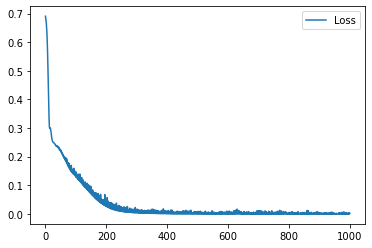

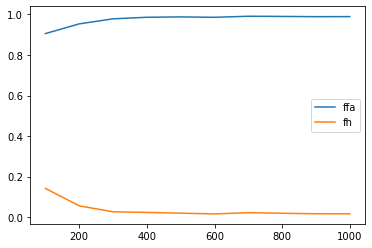

In [140]:
plt.figure()
plt.plot(range(1000), loss, label='Loss')
plt.legend()    
plt.figure()
plt.plot(range(100, 1100, 100), ffa, label='ffa')
plt.plot(range(100, 1100, 100), fh, label='fh')
plt.legend()    

In [141]:
model1 = DeepNet(layerSize=[256]+[256, 150, 81]+[81])
criterion1 = torch.nn.BCELoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr = 0.001)
model2 = DeepNet(layerSize=[81]+[81, 100, 128]+[256])
criterion2 = torch.nn.MSELoss(size_average = False)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 0.001)
sem_data = np.array(sem_data)
ffa = []
fh = []
loss = []
train(data, sem_data, model1, criterion1, optimizer1, 450)
features = test_class(data=data, target=sem_data, model=model1)
train(features, data, model2, criterion2, optimizer2, 450)
pred, err = test(data=features, target=data, model=model2)
ffa += [np.mean(err[0])]
fh += [np.mean(err[1])]

In [142]:
features = test_class(data=serif, target=sem_data, model=model1)
pred, err = test(data=features, target=data, model=model2)
ffa = [err[1]]
fh = [err[0]]

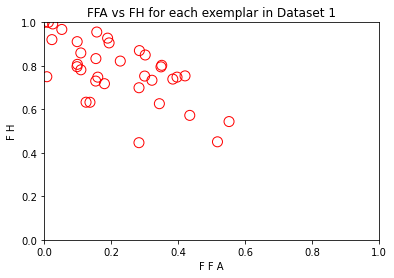

In [143]:
plt.scatter(ffa, fh, s=100, facecolors='none', edgecolors='r')
plt.title("FFA vs FH for each exemplar in Dataset 1")
plt.xlabel('F F A') 
plt.ylabel('F H') 
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

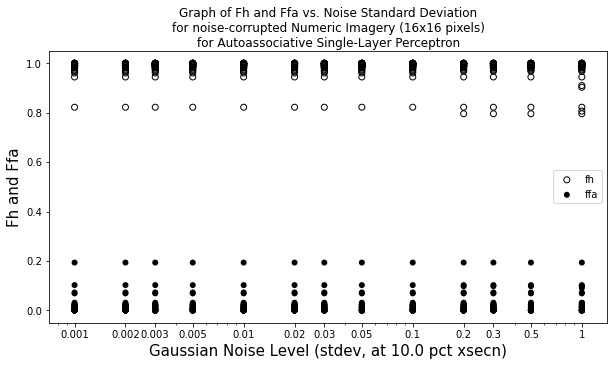

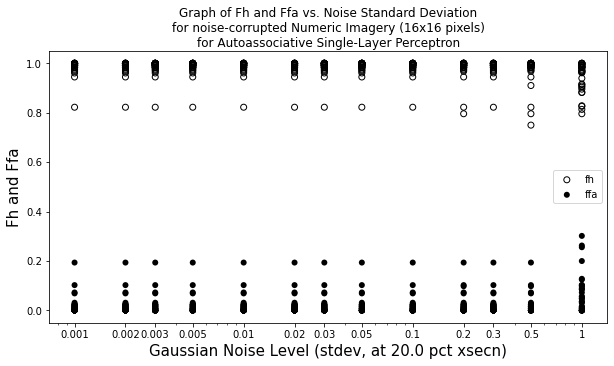

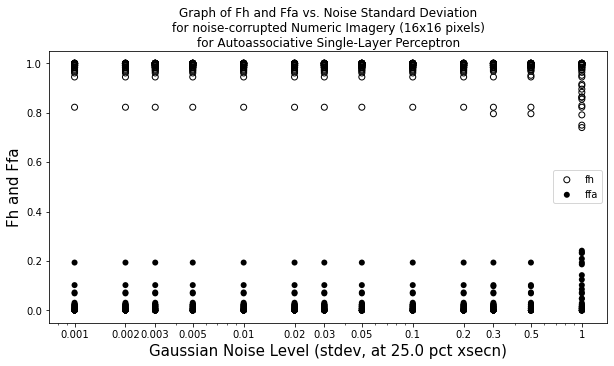

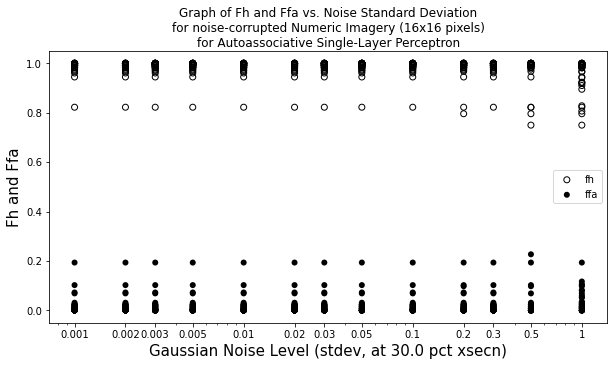

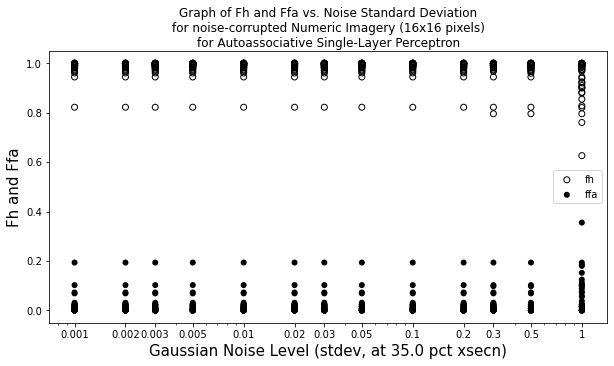

In [147]:
dfa = [pd.DataFrame()]*5
dfh = [pd.DataFrame()]*5
sigma = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
cxs = [0.1, 0.2, 0.25, 0.3, 0.35]
for i, cx in enumerate(cxs):
    ffa, fh = [], []
    dfa[i].index.name = 'Image ID'
    dfh[i].index.name = 'Image ID'
    for s in range(13):
        noisy_data = []
        for d in data:
            nd = add_noise(np.copy(d), cx, sigma[s])
            noisy_data.append(normalize(nd))
        target_values = generate_rescaled_inputs(data)
        features = test_class(data=noisy_data, target=sem_data, model=model1)
        pred, err = test(data=features, target=data, model=model2)
        predicted_values = pred
        # for i in range(10):
        #     axs[i, s].imshow(predicted_values[i].reshape(16, 16))
        h, a = compute_error_metrics(target_values, predicted_values)
        ffa += a
        fh += h
        dfa[i]['%s' %sigma[s]] = a
        dfh[i]['%s' %sigma[s]] = h
    x = [[s]*36 for s in sigma]
    plt.figure(figsize=(10, 5))
    plt.title(("Graph of Fh and Ffa vs. Noise Standard Deviation\n"
        "for noise-corrupted Numeric Imagery (16x16 pixels)\n"
        "for Autoassociative Single-Layer Perceptron"), loc='center', wrap=True)
    plt.xlabel(f'Gaussian Noise Level (stdev, at {cx*100} pct xsecn)', size=15)
    plt.ylabel('Fh and Ffa', size=15)
    plt.xscale('log')
    plt.xticks(sigma, sigma)
    plt.scatter(x, fh, label='fh', facecolors='none', edgecolors='black')
    plt.scatter(x, ffa, label='ffa', facecolors='black', edgecolors='none')
    plt.legend()

In [148]:
from IPython.display import display
for i, cx in enumerate(cxs):
    print(f'ffa values at stdev for {cx*100} xsecn')
    display(dfa[i])

ffa values at stdev for 10.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798
1,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.098039,0.098039,0.098039
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007692,0.038462
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007937
4,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194
5,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.015152,0.022727
6,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727
7,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.184932
8,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424


ffa values at stdev for 20.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798
1,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.098039,0.098039,0.098039
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007692,0.038462
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007937
4,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194
5,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.015152,0.022727
6,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727
7,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.184932
8,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424


ffa values at stdev for 25.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798
1,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.098039,0.098039,0.098039
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007692,0.038462
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007937
4,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194
5,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.015152,0.022727
6,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727
7,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.184932
8,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424


ffa values at stdev for 30.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798
1,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.098039,0.098039,0.098039
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007692,0.038462
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007937
4,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194
5,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.015152,0.022727
6,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727
7,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.184932
8,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424


ffa values at stdev for 35.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798,0.193798
1,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.098039,0.098039,0.098039
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007692,0.038462
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007937
4,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194,0.007194
5,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.015152,0.022727
6,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727
7,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.184932
8,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424,0.025424


In [149]:
from IPython.display import display
for i, cx in enumerate(cxs):
    print(f'fh values at stdev for {cx*100} xsecn')
    display(dfh[i])

fh values at stdev for 10.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882
1,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.796117,0.796117,0.796117
2,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.960317,0.920635
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.984615
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.983871,0.975806
6,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.900000
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754


fh values at stdev for 20.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882
1,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.796117,0.796117,0.796117
2,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.960317,0.920635
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.984615
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.983871,0.975806
6,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.900000
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754


fh values at stdev for 25.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882
1,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.796117,0.796117,0.796117
2,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.960317,0.920635
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.984615
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.983871,0.975806
6,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.900000
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754


fh values at stdev for 30.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882
1,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.796117,0.796117,0.796117
2,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.960317,0.920635
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.984615
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.983871,0.975806
6,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.900000
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754


fh values at stdev for 35.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882,0.944882
1,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.961165,0.796117,0.796117,0.796117
2,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.960317,0.920635
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.984615
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.983871,0.975806
6,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935,0.991935
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.900000
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754
